In [1]:
from __future__ import print_function
import morphs
import scipy as sp
import pandas as pd

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
import itertools

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
folder = morphs.paths.FIGURES_DIR / "neurometrics"

In [3]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    print(num_shuffles, path.name)

8 ks_df_8.pkl
64 ks_df_64.pkl
1024 ks_df_1024.pkl
2048 ks_df_2048.pkl


In [4]:
def calc_sig_df(num_shuffles, all_ks_df):
    floor_val = 1.0 / num_shuffles
    all_ks_df.loc[all_ks_df["p"] < floor_val, "p"] = floor_val
    all_ks_df["ks_p_floored"] = all_ks_df["ks_p_unshuffled"]
    all_ks_df.loc[all_ks_df["ks_p_floored"] < floor_val, "ks_p_floored"] = floor_val
    for sym, crit in (("*", 0.05), ("**", 0.01), ("***", 0.001)):
        all_ks_df[sym] = all_ks_df["p"] < crit
        all_ks_df["ks" + sym] = all_ks_df["ks_p_unshuffled"] < crit
    all_ks_df["count"] = 1
    sig_df = all_ks_df.groupby("class").agg("sum")
    sig_df["floor_count"] = (
        all_ks_df[all_ks_df["p"] <= floor_val].groupby("class").agg("sum")["count"]
    )
    return sig_df, floor_val

In [5]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    sig_df, floor_val = calc_sig_df(num_shuffles, all_ks_df)
    print(sig_df)

                    ks_p_shuffled  ks_stat_unshuffled  ks_p_unshuffled  \
class                                                                    
diff training cond      45.957414           28.751953        22.449216   
naive                   78.051270           47.765625        39.299355   
same training cond      21.442262           14.041992         6.829091   
self                    11.548666            4.783203         5.592820   

                         p  ks_p_floored    *   ks*   **  ks**  ***  ks***  \
class                                                                        
diff training cond  18.125     27.592639  0.0  40.0  0.0  31.0  0.0   24.0   
naive               22.750     49.694989  0.0  87.0  0.0  64.0  0.0   24.0   
same training cond   5.875     10.149538  0.0  26.0  0.0  13.0  0.0    7.0   
self                 2.500      6.646834  0.0   9.0  0.0   3.0  0.0    0.0   

                    count  floor_count  
class                                   
diff

In [6]:
def plot_neurometric_p_values(
    all_ks_df, sig_df, floor_val, y="p", log_y=True, ax=None, **kwargs
):
    class_order = [
        "naive",
        "trained",
        "diff training cond",
        "same training cond",
        "self",
    ]
    class_order = [cls for cls in class_order if cls in all_ks_df["class"].unique()]
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    if not ax:
        f = plt.figure(figsize=(4 * len(class_order), 5))
        ax = f.gca()
    if log_y:
        ax.set_yscale("log")
    plt.yticks([1, 0.05, 0.01, 0.001], ["1", ".05", ".01", ".001"])
    g = sns.swarmplot(
        data=all_ks_df, x="class", order=class_order, y=y, size=5, ax=ax, **kwargs
    )

    if y is "p":
        for i, cls in enumerate(class_order):
            if cls in sig_df.index:
                if sig_df.loc[cls, "floor_count"] > 0:
                    label = "%d/%d" % (
                        sig_df.loc[cls, "floor_count"],
                        sig_df.loc[cls, "count"],
                    )
                    ax.annotate(
                        label,
                        xy=(0.1 + i, floor_val * 1.1),
                        arrowprops=dict(arrowstyle="->", color="k"),
                        xytext=(0.2 + i, floor_val * 2.0),
                    )
    ax.set_title("probability of fitting neuromorphic curves by chance")

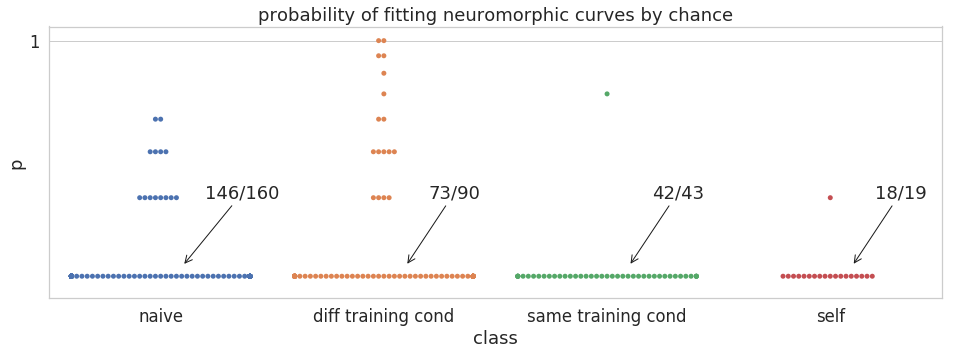

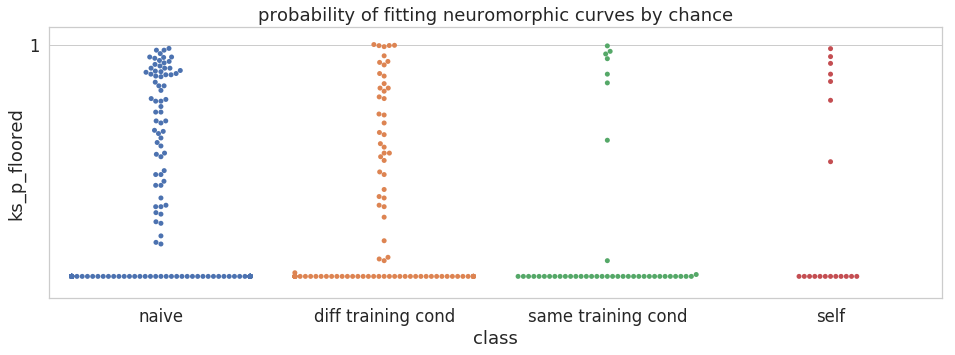

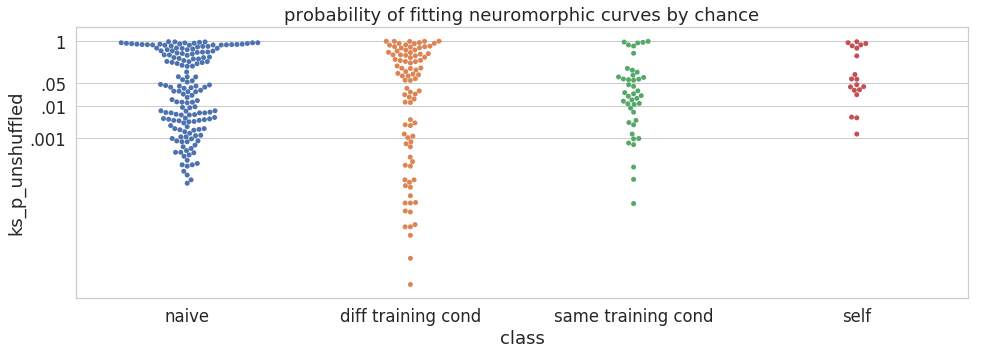

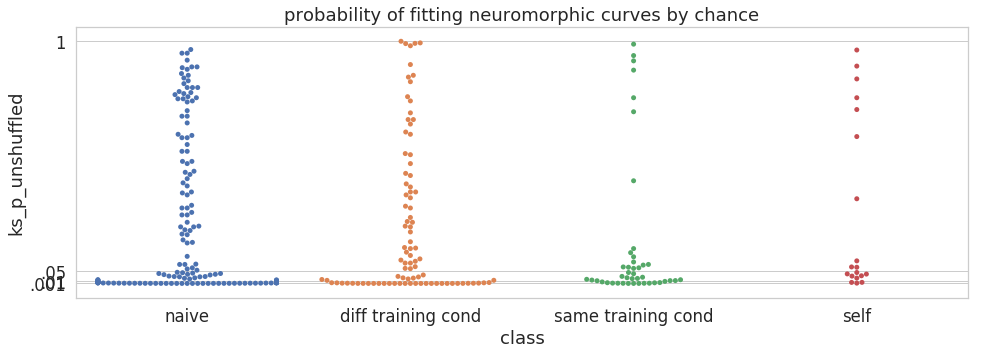

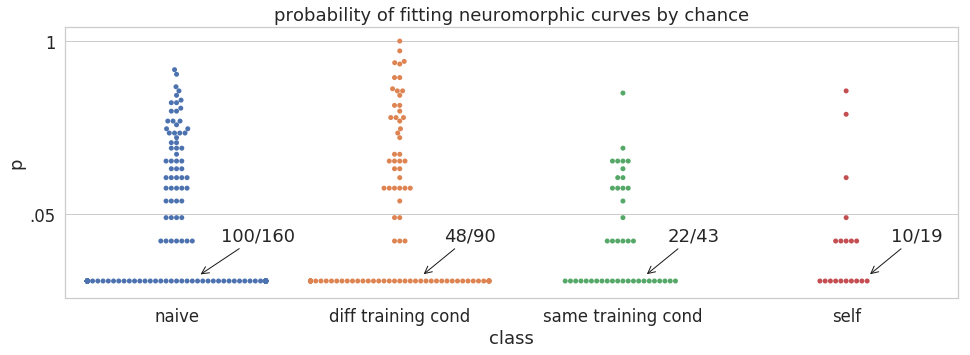

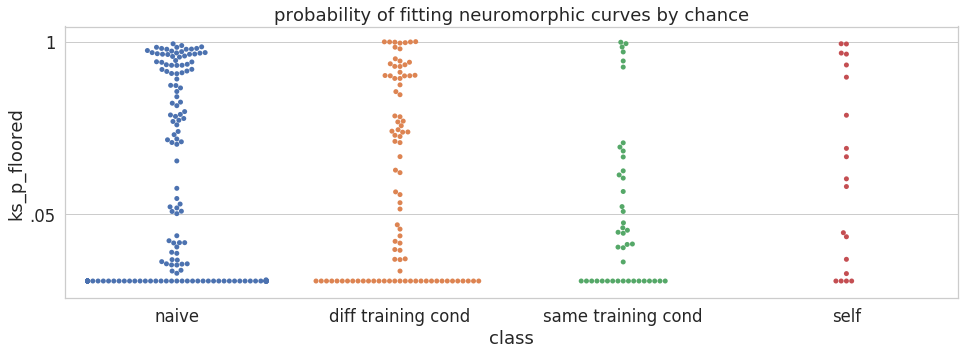

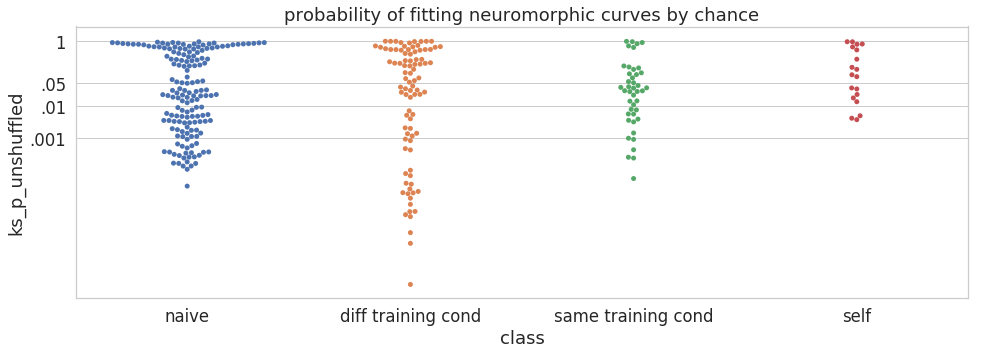

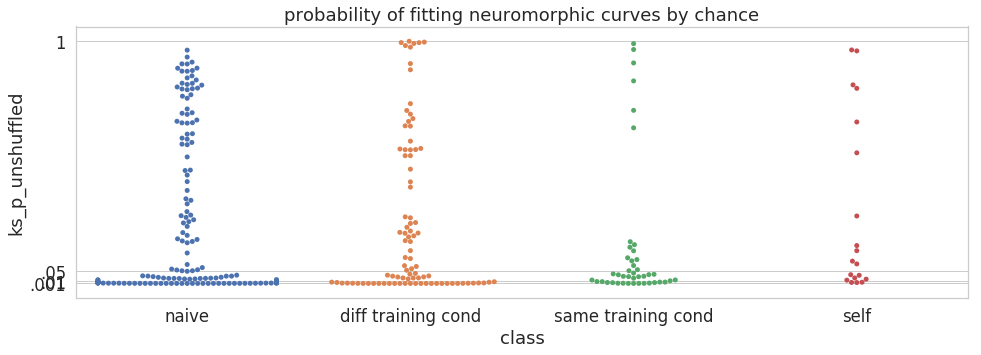

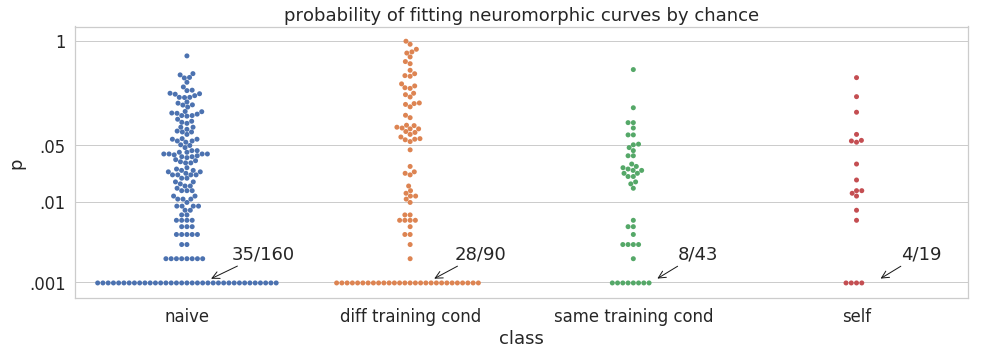

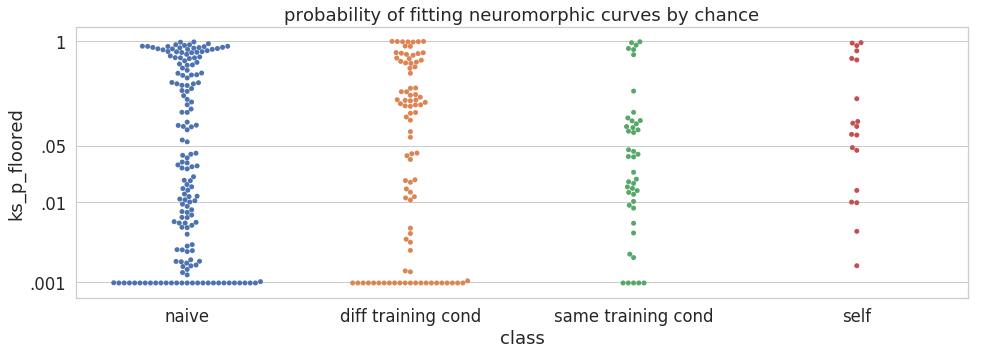

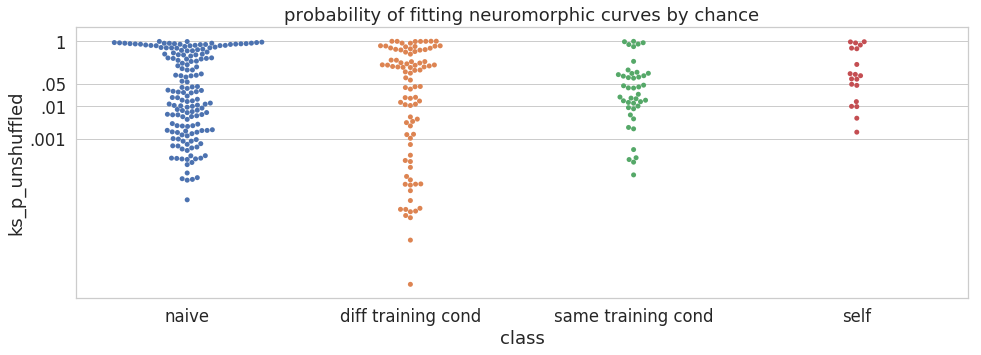

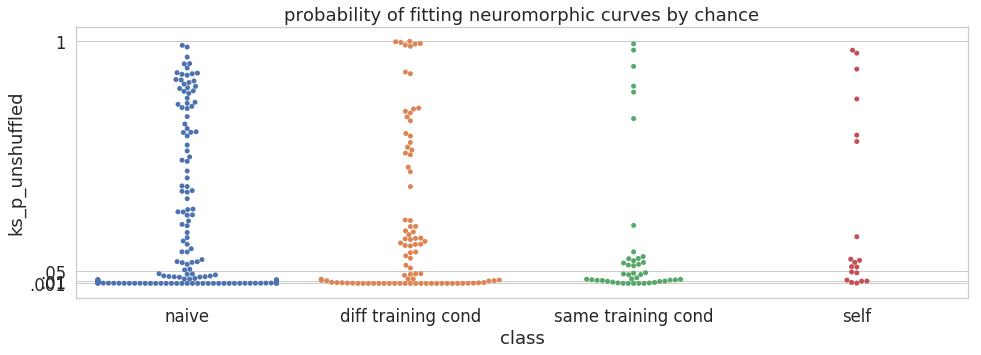

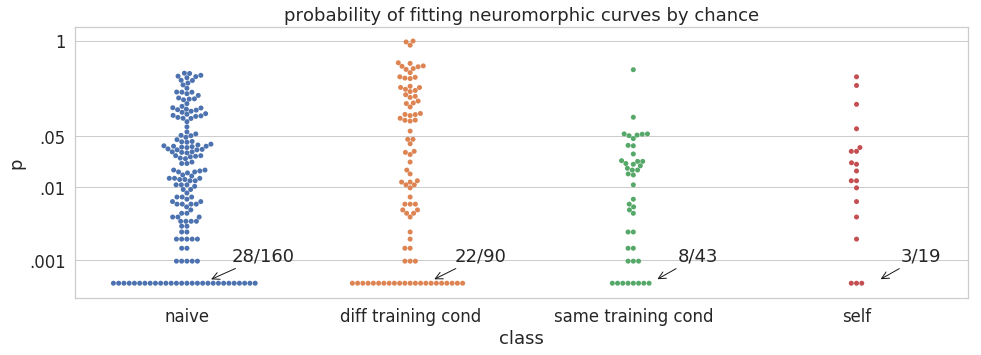

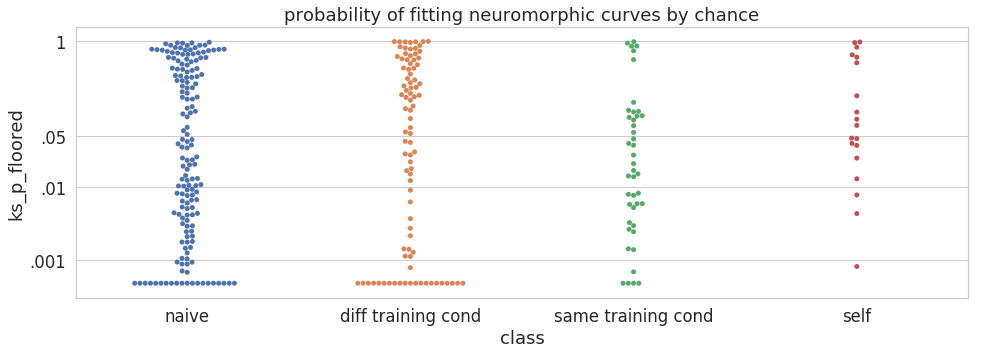

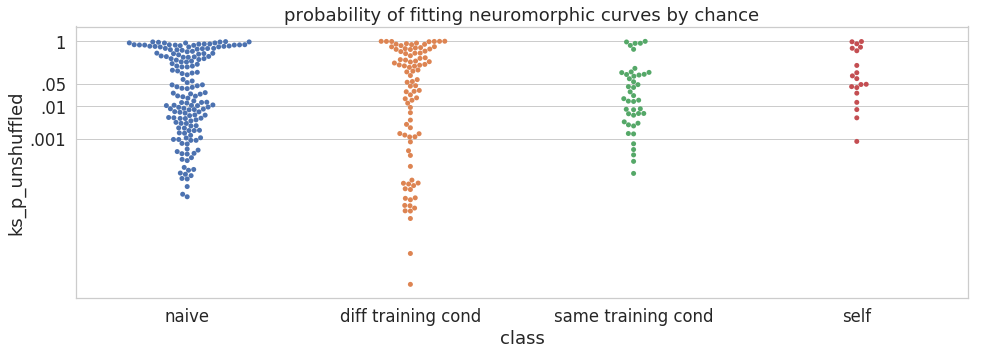

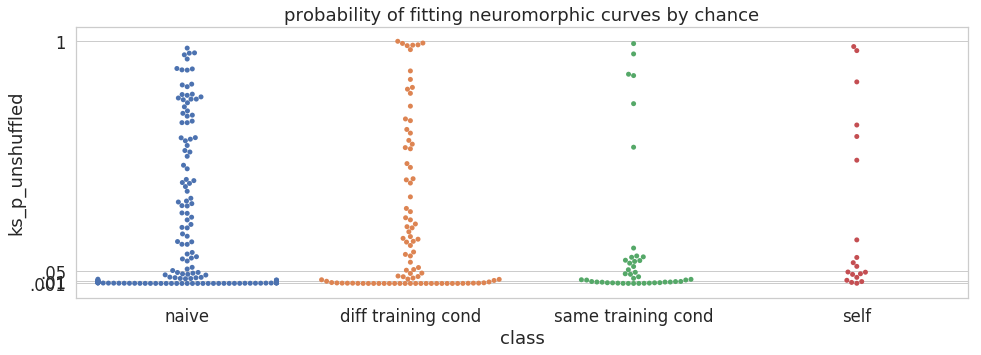

In [7]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    morphs.data.parse.ephys_class(
        all_ks_df,
        behavior_subj_label="subj",
        neural_subj_label="neuro_subj",
        split_training_cond=True,
        split_self=True,
    )
    sig_df, floor_val = calc_sig_df(num_shuffles, all_ks_df)
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val)
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="ks_p_floored")
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="ks_p_unshuffled")
    plot_neurometric_p_values(
        all_ks_df, sig_df, floor_val, y="ks_p_unshuffled", log_y=False
    )

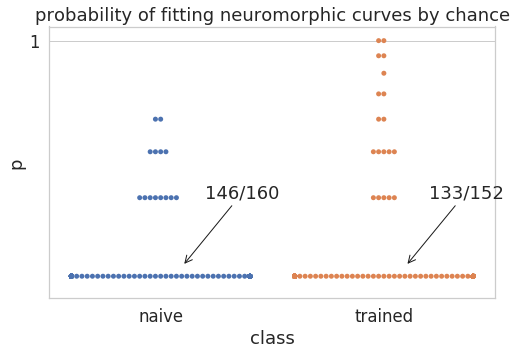

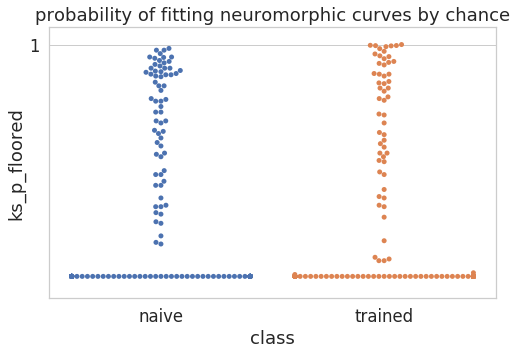

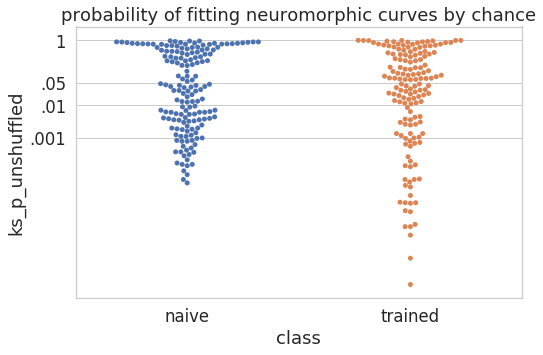

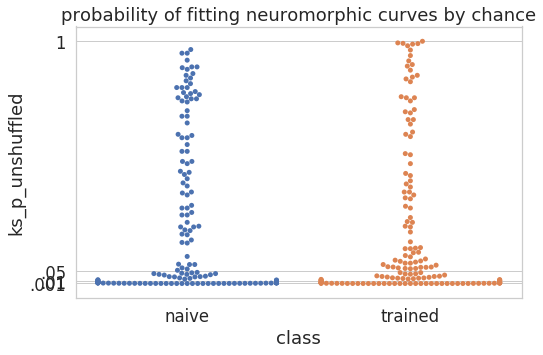

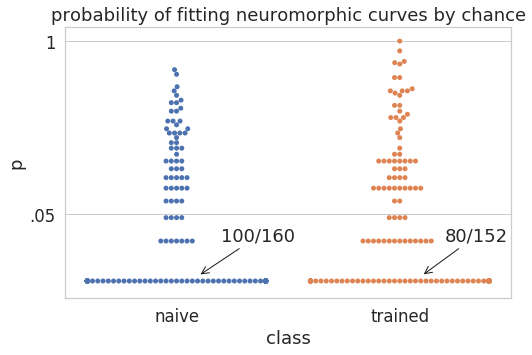

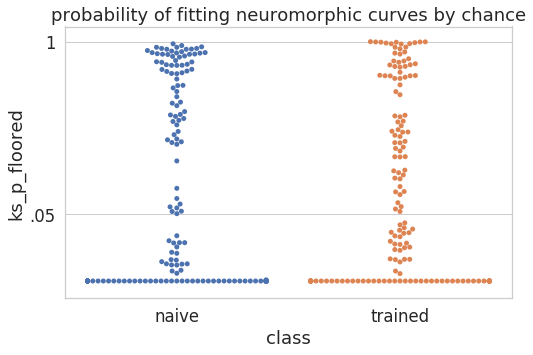

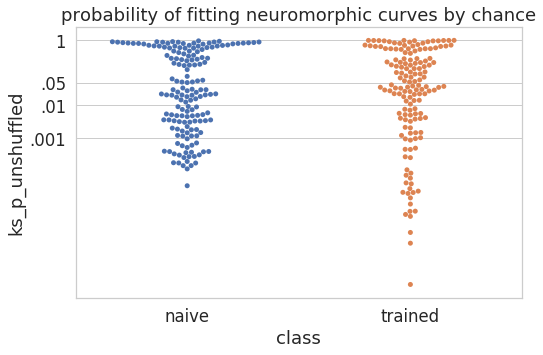

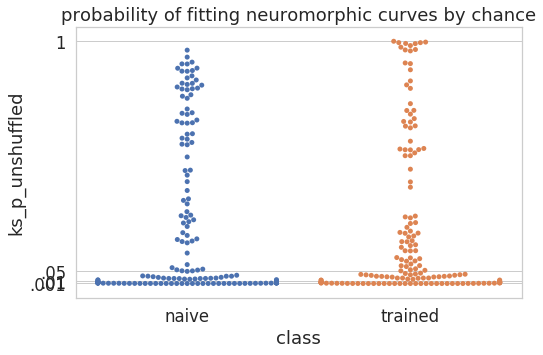

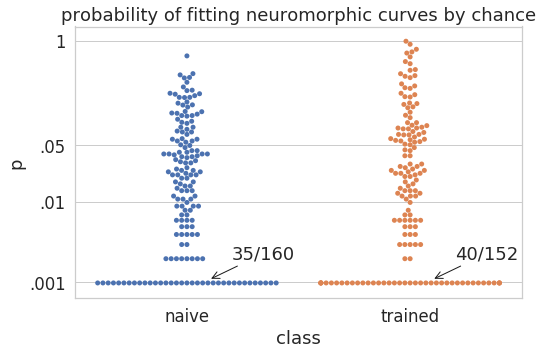

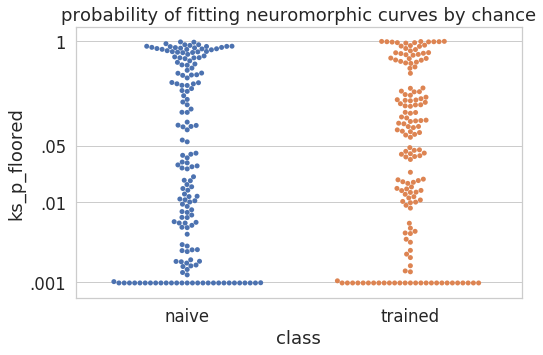

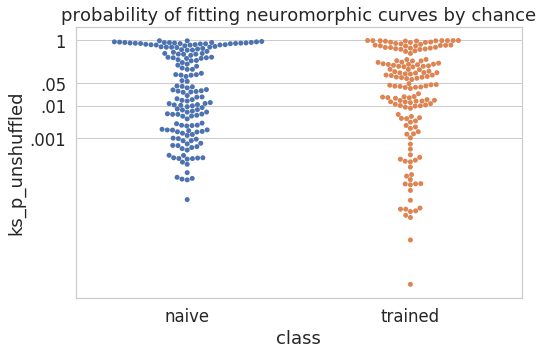

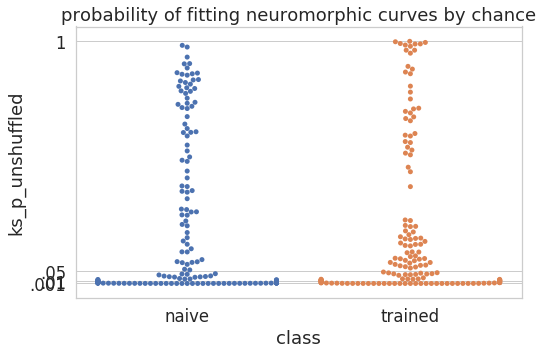

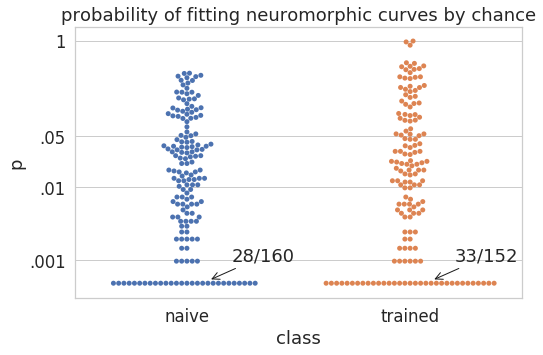

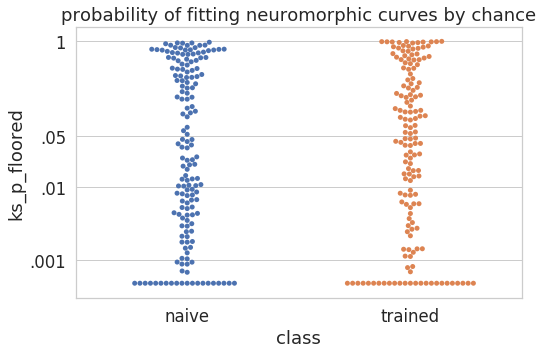

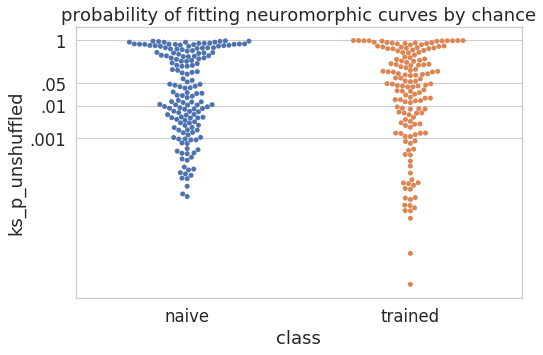

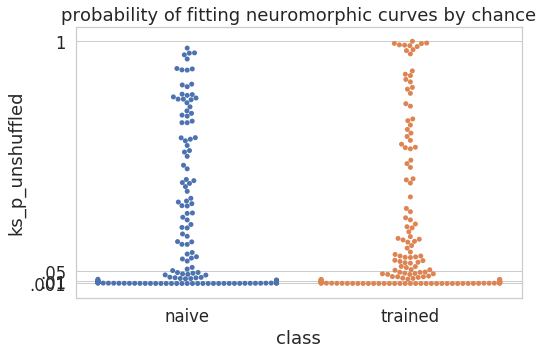

In [8]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    morphs.data.parse.ephys_class(
        all_ks_df,
        behavior_subj_label="subj",
        neural_subj_label="neuro_subj",
        split_training_cond=False,
        split_self=False,
    )
    sig_df, floor_val = calc_sig_df(num_shuffles, all_ks_df)
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val)
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="ks_p_floored")
    plot_neurometric_p_values(all_ks_df, sig_df, floor_val, y="ks_p_unshuffled")
    plot_neurometric_p_values(
        all_ks_df, sig_df, floor_val, y="ks_p_unshuffled", log_y=False
    )

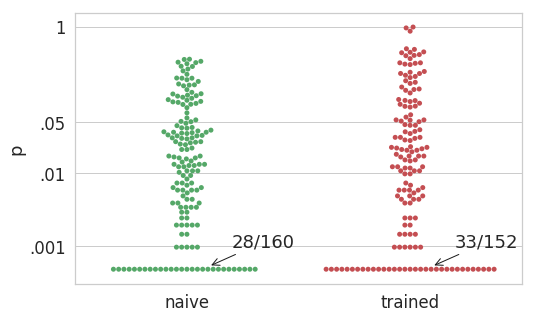

In [9]:
plot_neurometric_p_values(all_ks_df, sig_df, floor_val, palette=sns.color_palette()[2:])
ax = plt.gca()
ax.set_title("")
ax.set_xlabel("")
morphs.plot.savefig(plt.gcf(), "neurometric-p", folder=folder)

In [10]:
def pairwise_sig(all_ks_df, on="p"):
    gb = all_ks_df.groupby("class")
    for cls1, cls2 in itertools.combinations(gb.groups.keys(), 2):
        d, p = sp.stats.mstats.ks_twosamp(
            gb.get_group(cls1)[on].values, gb.get_group(cls2)[on].values
        )
        print(
            cls1,
            "vs",
            cls2,
            "   p =",
            p,
            "    bonferonni p =",
            p * len(list(itertools.combinations(gb.groups.keys(), 2))),
        )

In [11]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    morphs.data.parse.ephys_class(
        all_ks_df,
        behavior_subj_label="subj",
        neural_subj_label="neuro_subj",
        split_training_cond=True,
        split_self=True,
    )
    for on in ["p", "ks_p_unshuffled"]:
        print(num_shuffles, on)
        pairwise_sig(all_ks_df, on=on)

8 p
diff training cond vs naive    p = 0.5253074228604131     bonferonni p = 3.1518445371624786
diff training cond vs same training cond    p = 0.4018190548489867     bonferonni p = 2.41091432909392
diff training cond vs self    p = 0.8989114568617522     bonferonni p = 5.393468741170514
naive vs same training cond    p = 0.9990093980640685     bonferonni p = 5.994056388384411
naive vs self    p = 1.0     bonferonni p = 6.0
same training cond vs self    p = 1.0     bonferonni p = 6.0
8 ks_p_unshuffled
diff training cond vs naive    p = 0.048142544591651425     bonferonni p = 0.28885526754990853
diff training cond vs same training cond    p = 0.028258060481736715     bonferonni p = 0.1695483628904203
diff training cond vs self    p = 0.13820584570178823     bonferonni p = 0.8292350742107294
naive vs same training cond    p = 0.029203618795855105     bonferonni p = 0.17522171277513063
naive vs self    p = 0.11022553127364458     bonferonni p = 0.6613531876418675
same training cond vs sel

In [12]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    morphs.data.parse.ephys_class(
        all_ks_df,
        behavior_subj_label="subj",
        neural_subj_label="neuro_subj",
        split_training_cond=False,
        split_self=False,
    )
    for on in ["p", "ks_p_unshuffled"]:
        print(num_shuffles, on)
        pairwise_sig(all_ks_df, on=on)

8 p
naive vs trained    p = 0.9742539105842578     bonferonni p = 0.9742539105842578
8 ks_p_unshuffled
naive vs trained    p = 0.2679055245777387     bonferonni p = 0.2679055245777387
64 p
naive vs trained    p = 0.43359693340238986     bonferonni p = 0.43359693340238986
64 ks_p_unshuffled
naive vs trained    p = 0.17269420006711905     bonferonni p = 0.17269420006711905
1024 p
naive vs trained    p = 0.7775320454183591     bonferonni p = 0.7775320454183591
1024 ks_p_unshuffled
naive vs trained    p = 0.3534975330908757     bonferonni p = 0.3534975330908757
2048 p
naive vs trained    p = 0.5653552260658834     bonferonni p = 0.5653552260658834
2048 ks_p_unshuffled
naive vs trained    p = 0.420955666429177     bonferonni p = 0.420955666429177


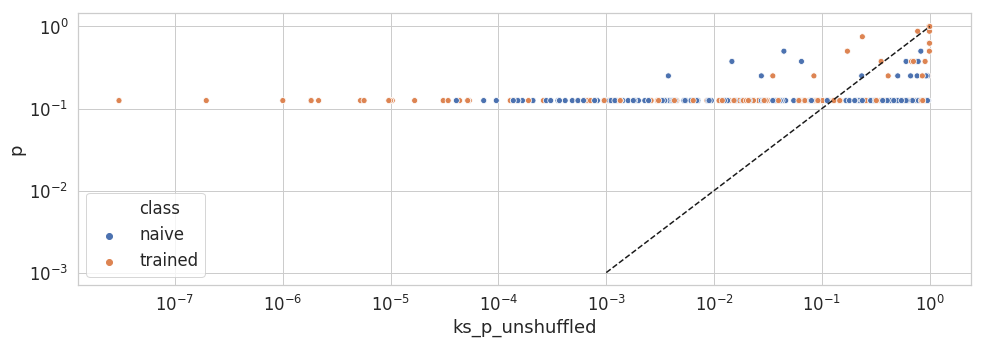

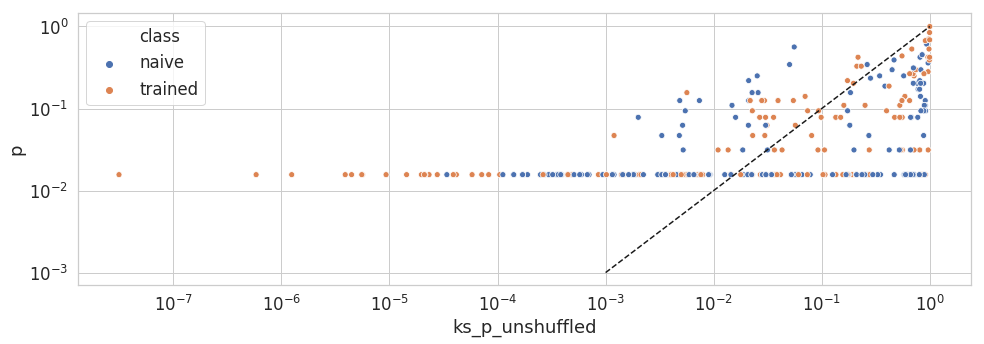

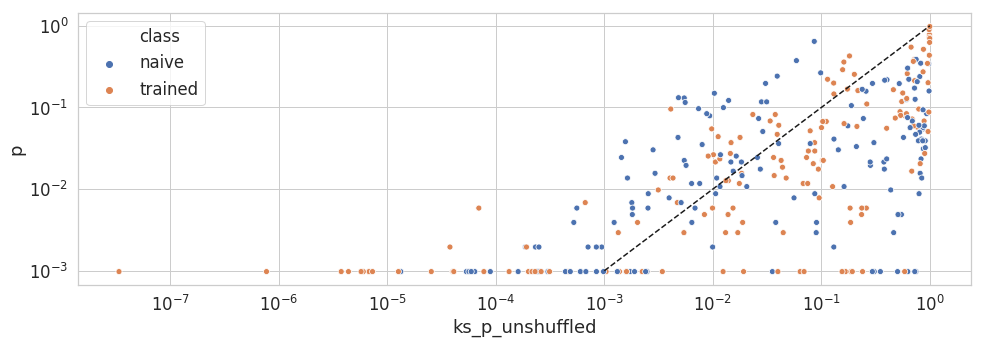

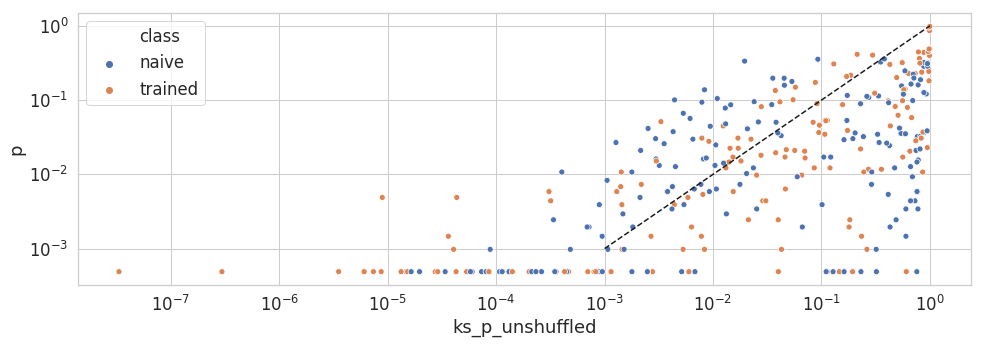

In [13]:
for path in morphs.paths.KS_DF_DIR.glob("*.pkl"):
    num_shuffles = morphs.data.parse.num_shuffles(path)
    all_ks_df = morphs.load.ks_df(num_shuffles)
    class_order = [
        "naive",
        "trained",
        "diff training cond",
        "same training cond",
        "self",
    ]
    class_order = [cls for cls in class_order if cls in all_ks_df["class"].unique()]
    f = plt.figure(figsize=(16, 5))
    ax = f.gca()
    ax.set_yscale("log")
    ax.set_xscale("log")
    sns.scatterplot(
        x="ks_p_unshuffled",
        y="p",
        hue="class",
        hue_order=class_order,
        data=all_ks_df,
        ax=ax,
    )
    unit_line = [1e-3, 1]
    plt.plot(unit_line, unit_line, "k--")